# Week 3: Logistic Regression - Implementation

# Part 1 - Logistic Regression - Binary Classification

_______________

## Setting the Scene

In the first part of this exercise, we'll build a logistic regression model to predict whether a student gets admitted to a university:

1. Suppose that you are the administrator of a university department and you want to determine each applicant's chance of admission based on their results on two exams. 


2. You have historical data from previous applicants that you can use as a training set for logistic regression.  


3. For each training example, you have the applicant's scores on two exams and the admissions decision.  

To accomplish this, we're going to build a classification model that estimates the probability of admission $y$ based on the exam scores $x$.

# Step 1 - Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Step 1 - Importing the Data

In [2]:
import os
path = os.getcwd() + '\data\ex2data1.txt'
data = pd.read_csv(path, header=None, names=['Exam 1', 'Exam 2', 'Admitted'])
data.head()

,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


# Step 3 - Do some initial analysis!

In [3]:
data.describe()

,Exam 1,Exam 2,Admitted
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


# Step 4 - Plot the data

Let's create a scatter plot of the two scores and use color coding to visualize if the example is positive (admitted) or negative (not admitted).

Text(0,0.5,'Exam 2 Score')

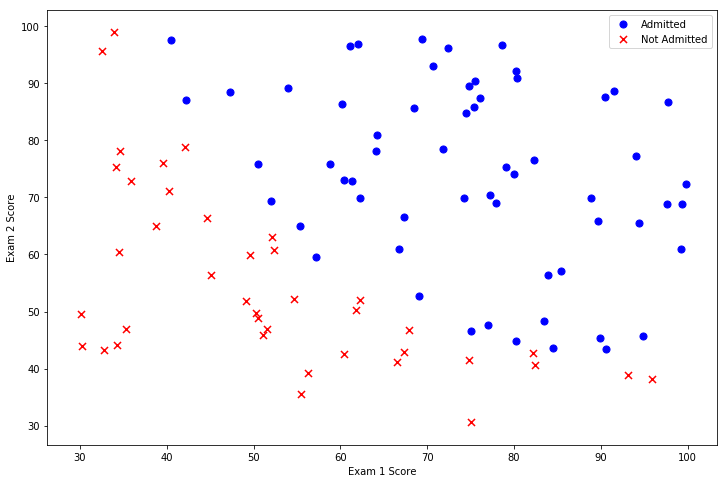

In [4]:
positive = data[data['Admitted'].isin([1])]

# Returns only the examples whereby the student was admitted, i.e. there is a 1 in the 'Admitted' column.

negative = data[data['Admitted'].isin([0])]

# Returns only the examples whereby the student was rejected, i.e. there is a 0 in the 'Admitted' column.

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['Exam 1'], positive['Exam 2'], s=50, c='b', marker='o', label='Admitted')
ax.scatter(negative['Exam 1'], negative['Exam 2'], s=50, c='r', marker='x', label='Not Admitted')
ax.legend()
ax.set_xlabel('Exam 1 Score')
ax.set_ylabel('Exam 2 Score')

It looks like there is a clear decision boundary between the two classes.  Now we need to implement logistic regression so we can train a model to predict the outcome.  The equations implemented in the following code samples are detailed in "ex2.pdf" in the "exercises" folder.

# Step 5 - Define the Training Dataset & Target Variables

Now we need to do some setup, similar to what we did in exercise 1 for linear regression.

### (a) Enable Vectorization

As with Linear Regression, we need to add a column of ones to the training set to enable matrix multiplication for cost and gradient calculations.

In [5]:
# add a ones column - this makes the matrix multiplication work out easier
data.insert(0, 'Ones', 1)

Which means our dataset now looks like this:

In [6]:
data.head()

,Ones,Exam 1,Exam 2,Admitted
0,1,34.623660,78.024693,0
1,1,30.286711,43.894998,0
2,1,35.847409,72.902198,0
3,1,60.182599,86.308552,1
4,1,79.032736,75.344376,1


### (b) Define the Training Data & Target Variable

Now let's do some variable intialization.

In [7]:
# set X (training data) and y (target variable)

cols = data.shape[1]
# returns the value 4, i.e. to reflect that there are x 4 columns in our table.

X = data.iloc[:,0:cols-1]
# i.e. X includes ALL rows but only the FIRST 3 columns.  Note: index 0 is the column of "Ones".  In other words, X is a matrix of ALL INPUT VARIABLES, i.e. x0 (Ones), x2 (Exam 1) and x3 (Exam 2).  

y = data.iloc[:,cols-1:cols]
# i.e. y includes ALL rows but only the last column "Admitted".  In other words, y is a matrix of all OUTPUT VARIABLES, i.e. all Addmitted / Not Addmitted results for each training example.

### (c) Converting X and y to numpy matrices

In [8]:
# convert to numpy arrays and initalize the parameter array theta
X = np.array(X.values)
y = np.array(y.values)

### (d) Initialise theta

In [9]:
theta = np.zeros(3)

### (e) Checking the matrices shapes

Let's quickly check the shape of our arrays to make sure everything looks good.

In [10]:
X.shape, theta.shape, y.shape

((100, 3), (3,), (100, 1))

In other words:
    
* X = 100 rows x 3 columns;


* y = 100 rows x 1 column; and


* $\theta$ = 1 row x 3 column 

Note `.shape` will confirm the dimension of the array, and if the array is 1D, will simply return the number of columns in the format `(row,)`.  If the array is 2D, it will return in the format `(row, column`).



# Step 6 - Define the Sigmoid Function

Recall that this function is $h_\theta(x) = g(\theta^{(T)}x)$ where g is the sigmoid function $g(z) = \frac{1}{1 +e^{-z}}$.

The code for this is pretty simple:

In [11]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

Let's do a quick sanity check to make sure the function is working.

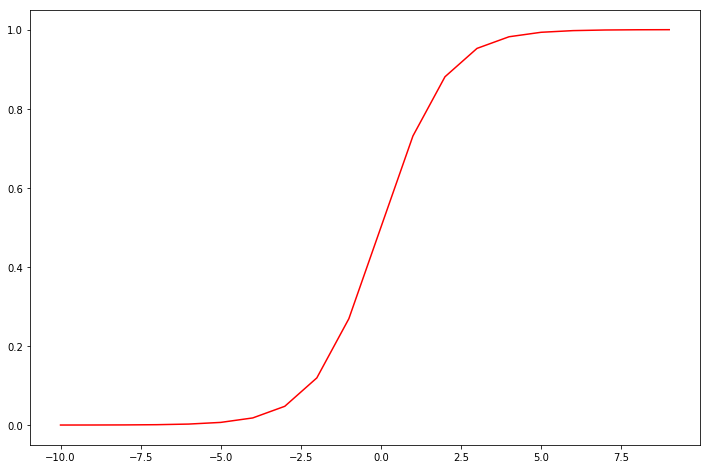

In [12]:
nums = np.arange(-10, 10, step=1)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(nums, sigmoid(nums), 'r')

# Step 7 - Define the Cost Function

Now we need to write the cost function to evaluate a solution.  Recall that the cost function in logistic regression is:

\begin{align}
J(\theta) = \frac{1}{m}\sum_{i=1}^{m}[-y^{(i)}log(h_\theta(x^{(i)})) - (1 - y^{(i)})log(1 - h_\theta(x^{(i)}))]
\end{align}

In [13]:
def cost(theta, X, y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    return np.sum(first - second) / (len(X))

### (a) Intuition: mapping formula to the code

`first = np.multiply(-y, np.log(sigmoid(X * theta.T)))` is equivalent to $-y^{(i)}log(h_\theta(x^{(i)}))$, which calculates the cost where $y = 1$.

`second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))` is equivalent to $(1 - y^{(i)})log(1 - h_\theta(x^{(i)}))$, which calculates the cost where $y = 0$.

and `return np.sum(first - second) / len(X))` executes the two parts of the formula together, sums it up and applies the fraction.

### (b) Running the Cost Function

Now let's compute the cost for our initial solution (0 values for theta).

In [14]:
cost(theta, X, y)

0.6931471805599453

# Step 8 - Define the Gradient Descent Function

Looks good.  Next we need a function to compute the gradient (parameter updates) given our training data, labels, and some parameters theta.  Recall that the gradient of the cost is a vector of the same length as $\theta$ where the j<sup>th</sup> element (for j = 0, 1, ... n) is defined as follows:

\begin{align}
\theta_j := \theta - \alpha \frac{\partial}{\partial \theta_j} J(\theta_0, \theta_1)
\end{align}

Which can be rewritten as:

\begin{align} 
\text{repeat until convergence \{} \\
\theta_j & := \theta_j - \alpha \dfrac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)} \\ 
\text{\}}
\end{align}

This is almost identical to the linear regression gradient descent function, except rather than swapping $\theta^{T}x$ for $h_\theta(x)$ in the above, we instead swap $\frac{1}{1 +e^{-\theta^{T}x}}$ in for $h_\theta(x)$ in the above:


In [15]:
def gradient(theta, X, y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - y
    # Calculates difference between predicted y value and actual y value for a given input x.  
    # Produces column vector of error scores for each example.
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        # Iterates through each column in the X matrix one by one, i.e. the Ones col, the Exam 1 col and Exam 2 col.  
        # In each such iteration each row of each such column is multipled by the corresponding row of the error vector.     
               
        grad[i] = np.sum(term) / len(X)
        # Sums all values from term (i.e. the particular column of the X matrix under iteration) and divides by number of
        # examples, in this case 100 (i.e. because m = 100).  This value is then assigned to the index of grad corresponding
        # to the iteration number.
    
    return grad
    # Returns matrix of updated parameters after one gradient step.

gradient(theta, X, y)

array([ -0.1       , -12.00921659, -11.26284221])

### (a) Breaking down the code

#### (i) Line 2

`theta = np.matrix(theta)` creates a numpy matrix containing our theta values, i.e. `matrix([0., 0., 0.])`.

#### (ii) Lines 3 & 4

`X = np.matrix(X)` creates a numpy matrix containing our X values.

`y = np.matrix(y)` creates a numpy matrix containign our y values.

#### (iii) Line 5
    
`parameters = int(theta.ravel().shape[1])`

`.ravel()` "<b>flattens</b>" the theta np matrix to a single row matrix, i.e. this `[[0., 0., 0.]]` becomes this `[0., 0., 0.]`

`.shape[1]` returns the <b>number of columns</b> of that matrix, i.e. 3.

`.int`returns the integer value of that in brackets, i.e. 3.

All of which is assigned to the variable, `parameters`.

<b>Purpose:</b> is the number of weights, in our case only three, i.e. $\theta_0$, $\theta_1$ and $\theta_2$.

#### (iv) Line 6

`grad = np.zeros(parameters)` creates a np matrix with a number of zeros equal to the number of parameters, i.e. 3 zeros so this: `[0., 0., 0.]`
 
#### (v) Line 7
 
`error = sigmoid(X * theta.T) - y` creates a new variable equivalent to $g(h_\theta(x^{(i)}) - y^{(i)})$.  This is calculating the cost for each training example.  Note that we take the sigmoid of the cost.

#### (vi) Line 8
  
`for i in range(parameters):` iterates through each column of the X matrix one by one.  As parameters = 3 this means perform all operations below it for index items 0, 1 and 2 of the X matrix, i.e. Ones col, Exam 1 col and Exam 2 col respectively.

#### (vii) Line 9

`term = np.multiply(error, X[:,i])` is the equivalent of $(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}$

To recap, this multiples each row of the errors vector (`error`) against each of the corresponding $x^{i}$ feature rows (`X[:,j]`) in X. 

So in each sub-iteration (i.e. within the second for loop `for j in range(parameters)`):

1. This is `error` x `X[:,0]`, which is each row of the error vector multiplied by each row of the $x_0$ vector (i.e. the "ones"); 


2. This is `error` x `X[:,1]`, which is each row of the error vector multiplied by each row of the $x_1$ vector (i.e. the "Exam 1" figures); and


3. This is `error` x `X[:,2]`, which is each row of the error vector multiplied by each row of the $x_2$ vector (i.e. the "Exam 2" figures).

#### (viii) Line 10

`grad[i] = np.sum(term) / len(X)` is the equivalent of $\frac{1}{m}\sum J(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}$


#### Note

We don't actually perform gradient descent in this function - we just compute a <b>single</b> gradient step.  

In the Andrew Ng exercise, an Octave function called "fminunc" is used to optimize the parameters given to the cost and gradient functions.  

Since we're using Python, we can use SciPy's "optimize" namespace to do the same thing.

# Step 9 - Running Gradient Descent (a single step)

Let's look at a single call to the gradient method using our data and initial paramter values of 0.

In [16]:
result = gradient(theta, X, y)
result

array([ -0.1       , -12.00921659, -11.26284221])

# Step 10 - Using SciPy's TNC to optimise parameters

Now we can use SciPy's truncated newton (TNC) implementation to find the optimal parameters.

In [17]:
import scipy.optimize as opt
result = opt.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y))
result

(array([-25.16131872,   0.20623159,   0.20147149]), 36, 0)

Let's explain these results:

1. <b>`[-25.16131872,   0.20623159,   0.20147149]`</b> are the optimised parameters.
<p>
    
2. <b>36</b> represents the number of function evaluations (aka gradient "steps" or "iterations") necessary to arrive at the optimal parameters.
    
<p>
3. <b>0</b> is a "return code" that means "Local minimum reached".  Other Return codes can be found [here](http://pageperso.lif.univ-mrs.fr/~francois.denis/IAAM1/scipy-html-1.0.0/generated/scipy.optimize.fmin_tnc.html).

# Step 11 - Checking the cost function with optimised parameters


Let's see what the our cost looks like with this solution.

In [18]:
cost(result[0], X, y)

0.20349770158947425

# Step 12 - Define Decision Boundary Function

Next we need a function that can map the probability that given an input $x$ it corresponds to $y = 1$ to a corresponding class, i.e. pass or fail.

To do so, we calculate the probability that $y = 1$ for each sample, and then use a decision boundary to map that value to either 1 (pass) or 0 (fail):

In [19]:
def predict(theta, X):
    probability = sigmoid(X * theta.T)
    # Calculates probability that y = 1 for a given set of x values.
    return [1 if x >= 0.5 else 0 for x in probability]
    # Sets the decision boundary, i.e. mapping the probability to a binary class, in this case 1 or 0.

# Step 13 - Plot the Decision Boundary

Text(0,0.5,'Exam 2 Score')

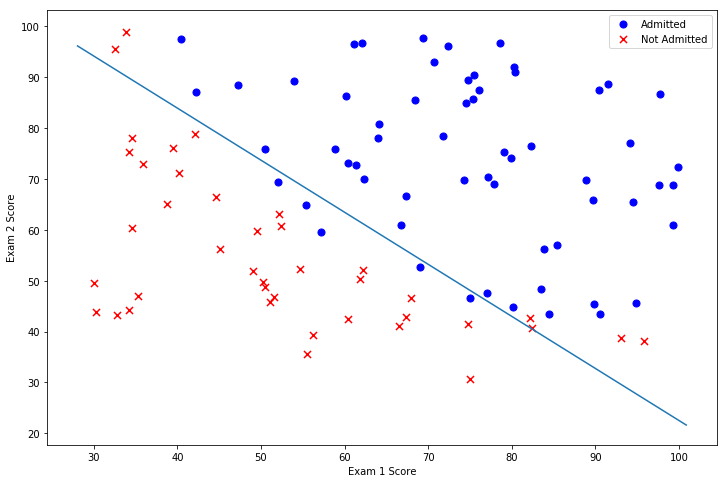

In [20]:
positive = data[data['Admitted'].isin([1])]

# Returns only the examples whereby the student was admitted, i.e. there is a 1 in the 'Admitted' column.

negative = data[data['Admitted'].isin([0])]

# Returns only the examples whereby the student was rejected, i.e. there is a 0 in the 'Admitted' column.

dec_boundary_plot_x = [np.min(X[:,1]-2), np.max(X[:,2]+2)]

dec_boundary_plot_y = -1/(result[0][2])*(result[0][0] + np.dot(result[0][1],dec_boundary_plot_x))

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['Exam 1'], positive['Exam 2'], s=50, c='b', marker='o', label='Admitted')
ax.scatter(negative['Exam 1'], negative['Exam 2'], s=50, c='r', marker='x', label='Not Admitted')
decision_boundary = plt.plot(dec_boundary_plot_x, dec_boundary_plot_y)
ax.legend()
ax.set_xlabel('Exam 1 Score')
ax.set_ylabel('Exam 2 Score')

# Step 14 - Scoring the Accuracy of our Classifier

We can then use this function to score the training accuracy of our classifier.

In [21]:
theta_min = np.matrix(result[0])
# Creates matrix of the optimised parameters.

predictions = predict(theta_min, X)
# Takes the optimised paramters and X as its arguments and produces a vector of 0s and 1s corresponding to the predicted
# values of y our algorithm generates.

correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]
# Compares result in predictions vector (a) against the actual y values (b).  If they match, returns 1.  If they do not
# match, returns 0.  Produces new vector of 0s and 1s representing whether our algorithm was correct / incorrect for each 
# prediction. See also here: https://www.codecademy.com/en/forum_questions/526269b2f10c604fc500b53c

accuracy = (sum(map(int, correct)) % len(correct))
# Calculates what % of our predicted y results were in fact correct when compared with the actual y values.  Concretely
# sum(map(int, correct)) counts the number of results that were correct, i.e. all the 1s, which returns a total of 89. 
# And len(correct) returns the length of the correct vector, i.e. 100 items.  % returns 89 as a % of 100, i.e. 89%

print ('accuracy = {0}%'.format(accuracy))

accuracy = 89%


Our logistic regression classifer correctly predicted if a student was admitted or not 89% of the time.  Not bad!  Keep in mind that this is training set accuracy though.  We didn't keep a hold-out set or use cross-validation to get a true approximation of the accuracy so this number is likely higher than its true perfomance (this topic is covered in a later exercise).

# Part 2 - Regularised Logistic Regression
-------------------

#### Setting the Scene

Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests.  From these two tests, you would like to determine whether the microchips should be accepted or rejected.  To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

# Step 1 - Import the Data

Similar to part 1, let's start by visualizing the data.

In [22]:
import os
path = os.getcwd() + '\data\ex2data2.txt'
data2 = pd.read_csv(path, header=None, names=['Test 1', 'Test 2', 'Accepted'])
data2.head()

,Test 1,Test 2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


Which reflects the following dimensions:
    
* Test 1 (i.e. $x_1$) = 100 rows x 1 column;


* Test 2 (i.e. $x_2$) = 100 rows x 1 column; 


* Test 1 and Test 2 (i.e. $X$) = 100 rows x 2 columns; and


* Accepted (i.e. $y$) = 100 rows x 1 column.

Note, once we add the additional column of ones for the $x_0$ feature (per later step below), the dimensions for $X$ alter as follows: 

* 100 rows x 2 columns &rightarrow; 100 rows x 3 columns.

# Step 2 - Visualise the Data

Text(0,0.5,'Test 2 Score')

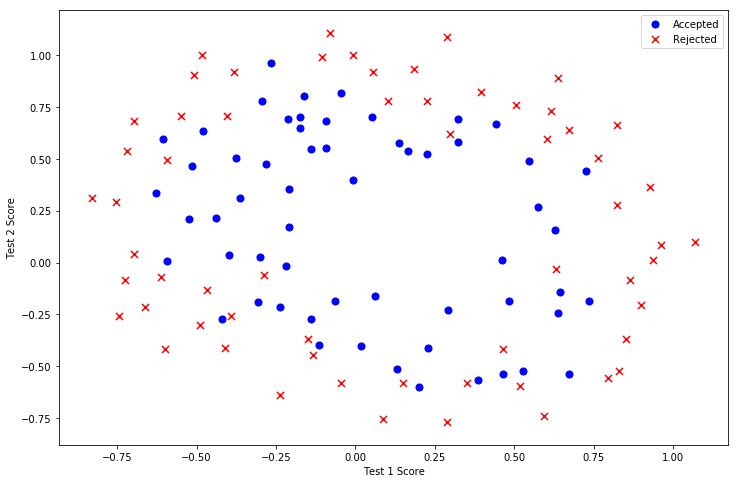

In [23]:
positive = data2[data2['Accepted'].isin([1])]
negative = data2[data2['Accepted'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['Test 1'], positive['Test 2'], s=50, c='b', marker='o', label='Accepted')
ax.scatter(negative['Test 1'], negative['Test 2'], s=50, c='r', marker='x', label='Rejected')
ax.legend()
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')

This data looks a bit more complicated than the previous example.  In particular, you'll notice that there is no linear decision boundary that will perform well on this data.  

# Step 3 - Create Polynomial Features

One way to deal with this using a linear technique like logistic regression is to construct features that are derived from polynomials of the original features.  Let's start by creating a bunch of polynomial features.

In [24]:
degree = 7

x1 = data2['Test 1']
# The x1 values

x2 = data2['Test 2']
# The x2 values

data2.insert(3, 'Ones', 1)
# .insert(3, 'Ones', 1) is adding as new index 3, a column headed 'Ones' with each element to be added being eqaul to 1.  # I.e. it adds to x0 = 1 values for each sample.

data2
for i in range(1, degree):
#Iterate from 1 - (degree-1), i.e. from 1 - 5 (inclusive)

    for j in range(0, i+1):
    # Iterate from 0 - (i-1) (inclusive)
        data2['F' + str(i) + str(j)] = np.power(x1, i-j) * np.power(x2, j)
        # First decides exponent for x1 using current values of (i) and (j)
        # Second decides exponent for x2 using current value of (j)
        # Third multiplies x1^n . x2^n to provide a new polynomial feature value
        # Fourth value assigned to new column headed with current value 

data2.drop('Test 1', axis=1, inplace=True)
data2.drop('Test 2', axis=1, inplace=True)

data2

,Accepted,Ones,F10,F11,F20,F21,F22,F30,F31,F32,...,F53,F54,F55,F60,F61,F62,F63,F64,F65,F66
0,1,1,0.051267,0.699560,0.002628,0.035864,0.489384,1.347453e-04,0.001839,0.025089,...,8.998098e-04,1.227829e-02,1.675424e-01,1.815630e-08,2.477505e-07,3.380660e-06,4.613055e-05,6.294709e-04,8.589398e-03,1.172060e-01
1,1,1,-0.092742,0.684940,0.008601,-0.063523,0.469143,-7.976812e-04,0.005891,-0.043509,...,2.763825e-03,-2.041205e-02,1.507518e-01,6.362953e-07,-4.699318e-06,3.470651e-05,-2.563226e-04,1.893054e-03,-1.398103e-02,1.032560e-01
2,1,1,-0.213710,0.692250,0.045672,-0.147941,0.479210,-9.760555e-03,0.031616,-0.102412,...,1.515091e-02,-4.907685e-02,1.589699e-01,9.526844e-05,-3.085938e-04,9.995978e-04,-3.237900e-03,1.048821e-02,-3.397345e-02,1.100469e-01
3,1,1,-0.375000,0.502190,0.140625,-0.188321,0.252195,-5.273438e-02,0.070620,-0.094573,...,1.781011e-02,-2.385083e-02,3.194040e-02,2.780914e-03,-3.724126e-03,4.987251e-03,-6.678793e-03,8.944062e-03,-1.197765e-02,1.604015e-02
4,1,1,-0.513250,0.465640,0.263426,-0.238990,0.216821,-1.352032e-01,0.122661,-0.111283,...,2.659554e-02,-2.412849e-02,2.189028e-02,1.827990e-02,-1.658422e-02,1.504584e-02,-1.365016e-02,1.238395e-02,-1.123519e-02,1.019299e-02
5,1,1,-0.524770,0.209800,0.275384,-0.110097,0.044016,-1.445130e-01,0.057775,-0.023098,...,2.543047e-03,-1.016696e-03,4.064690e-04,2.088401e-02,-8.349308e-03,3.338005e-03,-1.334515e-03,5.335313e-04,-2.133027e-04,8.527719e-05
6,1,1,-0.398040,0.034357,0.158436,-0.013675,0.001180,-6.306380e-02,0.005443,-0.000470,...,6.425385e-06,-5.546100e-07,4.787141e-08,3.977043e-03,-3.432803e-04,2.963039e-05,-2.557560e-06,2.207569e-07,-1.905473e-08,1.644718e-09
7,1,1,-0.305880,-0.192250,0.093563,0.058805,0.036960,-2.861892e-02,-0.017987,-0.011305,...,-6.648156e-04,-4.178462e-04,-2.626224e-04,8.190426e-04,5.147801e-04,3.235467e-04,2.033538e-04,1.278108e-04,8.033094e-05,5.048915e-05
8,1,1,0.016705,-0.404240,0.000279,-0.006753,0.163410,4.661648e-06,-0.000113,0.002730,...,-1.843363e-05,4.460706e-04,-1.079435e-02,2.173096e-11,-5.258619e-10,1.272520e-08,-3.079338e-07,7.451610e-06,-1.803196e-04,4.363507e-03
9,1,1,0.131910,-0.513890,0.017400,-0.067787,0.264083,2.295267e-03,-0.008942,0.034835,...,-2.361380e-03,9.199376e-03,-3.583858e-02,5.268249e-06,-2.052385e-05,7.995603e-05,-3.114897e-04,1.213490e-03,-4.727468e-03,1.841709e-02


Which equates to the below, where $F10 = x_1$, $F11 = x_2$, $F20 = x_1^{2}$, ... $F66 = x_2^{6}$

<img src="../Images/polynomials.png" width=100%/>

# Step 4 - Initialise the Variables

Initialize variables like we did in part 1.

In [25]:
# set X and y (remember from above that we moved the label to column 0)
cols = data2.shape[1]

X2 = data2.iloc[:,1:cols]
# Creates array of all X feature values

y2 = data2.iloc[:,0:1]
# Creates array of all y label values

# Below converts X2 and y2 from arrays to numpy arrays and initalize the parameter array theta
X2 = np.array(X2.values)
y2 = np.array(y2.values)
theta2 = np.zeros(28)

Now let's check the shape of `X2`, `y2` and `theta2`:

In [26]:
print(X2.shape)
print(y2.shape)
print(theta2.shape)

# X2_shape = np.array([X2.shape])
# y2_shape = np.array([y2.shape])
# theta2_np = np.array([[theta2]])
# theta2_shape = theta2_np.shape
# theta2_shape[2]


# print("X2 has {0} rows and {1} columns".format(X2_shape[0][0], X2_shape[0][1]))
# print("y2 has {0} rows and {1} columns".format(y2_shape[0][0], y2_shape[0][1]))
# print("theta2 has {0} rows and {1} columns".format(theta2_shape[1], theta2_shape[2]))

(118, 28)
(118, 1)
(28,)


In other words:
    
* X2 has 118 rows and 28 columns


* y2 has 118 rows and 1 column


* theta2 has 1 row and 28 columns

# Step 4 - Include the Regularization Term

Now we need to modify the cost and gradient functions from part 1 to include the regularization term.  First the cost function:

## (a) Regularizing the Cost Function

In [27]:
def costReg(theta, X, y, learningRate):
    # Below three lines format everything to numpy matrices
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    # Below is the left side of the cost function equation for where y = 1
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    
    # Below is the right side of the cost function for where y = 1
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    
    reg = (learningRate / 2 * len(X)) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    # Is the regularisation term, explained below.
    
    return np.sum(first - second) / (len(X)) + reg

Notice the `reg` term in the equation, which is equivalent to the $+\lambda \sum_{j=1}^{m} \theta_j^2$ at the far right in the below:

\begin{align}
J_{reg}(\theta) = \frac{1}{2m} \bigg[-y^{(i)}log(h_\theta(x^{(i)})) - (1 - y^{(i)})log(1 - h_\theta(x^{(i)})) + \lambda \sum_{j=1}^{m} \theta_j^2\bigg]
\end{align}

To recap, the `reg` term works as follows:

1. Recall that by convention we do not process $x_0$, hence `theta[:,1]` avoids index $0$ of the $\theta$ matrix, i.e. $x_0$, and instead returns index $1$ of the $\theta$ matrix, which corresponds to $x_1$.  


2. `theta.shape[1]` returns the number of columns in the $\theta$ matrix, in this case $28$.


3. Altogether then, `np.power(theta[:,1:theta.shape[1]], 2))` squares every $\theta$ value from index $1$ to index $n$.


4. `np.sum(np.power(theta[:,1:theta.shape[1]], 2))` sums each squared valued of $\theta$ resulting from step (3) above.


5. `learningRate` is $\lambda$.  This is a hyperparameter, i.e. a configuration external to the model and whose value cannot be estimated from the data, and is often tuned by the human.  It controls the effectiveness of the regularization term. 

## (b) Regularizing the Gradient Function

Now we need to add regularization to the gradient function.  Recall that it looks like this:


Plugging the above into the gradient descent algorithm looks like this:

\begin{align*} & \text{repeat until convergence:} \; \lbrace \newline \; & 
\theta_0 := \theta_0 - \alpha \frac{1}{m} \sum\limits_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) \cdot x_0^{(i)} \newline \; & 
\cdots  \newline \; & 
\theta_j := \theta_j - \alpha \frac{1}{m} \sum\limits_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) \cdot x_j^{(i)} + \frac{\lambda}{m}\theta_j & \newline 
\rbrace \end{align*}

Note that the first $\theta_0$ is left unprocessed.  Rearranging the above can make it simpler:

\begin{align*} & \text{repeat until convergence:} \; \lbrace \newline \; & 
\theta_0 := \theta_0 - \alpha \frac{1}{m} \sum\limits_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) \cdot x_0^{(i)} \newline \; & 
\cdots  \newline \; & 
\theta_j := \theta_j(1 - \alpha \frac{\lambda}{m}) - \alpha \frac{1}{m} \sum\limits_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) \cdot x_j^{(i)} & \newline 
\rbrace \end{align*}

This is implemented at lines 16 - 19 below (and also the above lines where they calculate the constituent ingredients obviously!):

In [28]:
def gradientReg(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        
        # As with the regularised cost function above, by convention we similarly don't process x_0 when applying
        # regularised gradient descent
        if (i == 0):
            grad[i] = np.sum(term) / len(X)
        else:
            grad[i] = (np.sum(term) / len(X)) + ((learningRate / len(X)) * theta[:,i])
    
    return grad

# Step 6 - Initialise the Learning Rate

Let's initialize our learning rate to a sensible value.  We can play with this later if necessary (i.e. if the penalization is too strong or not strong enough).

In [29]:
learningRate = 1

# Step 7 - Running our Regularized functions!

Now let's try calling our new regularized functions with the default (0) values for theta to make sure the calculations are working.

## (a) Running the Regularized Cost Function

In [30]:
costReg(theta2, X2, y2, learningRate)

0.6931471805599454

## (b) Running the Regularized Gradient Descent Function

In [31]:
gradientReg(theta2, X2, y2, learningRate)

array([8.47457627e-03, 1.87880932e-02, 7.77711864e-05, 5.03446395e-02,
       1.15013308e-02, 3.76648474e-02, 1.83559872e-02, 7.32393391e-03,
       8.19244468e-03, 2.34764889e-02, 3.93486234e-02, 2.23923907e-03,
       1.28600503e-02, 3.09593720e-03, 3.93028171e-02, 1.99707467e-02,
       4.32983232e-03, 3.38643902e-03, 5.83822078e-03, 4.47629067e-03,
       3.10079849e-02, 3.10312442e-02, 1.09740238e-03, 6.31570797e-03,
       4.08503006e-04, 7.26504316e-03, 1.37646175e-03, 3.87936363e-02])

# Step 8 - Optimising our Functions

Now we can use the same optimization function from part 1 to compute the optimal solution for all $theta$ values, i.e. from $\theta_0$ to $\theta_{28}$:

In [32]:
result2 = opt.fmin_tnc(func=costReg, x0=theta2, fprime=gradientReg, args=(X2, y2, learningRate))
result2

(array([ 2.49641208e-04,  1.37411984e-04,  2.77015167e-04, -4.35864169e-04,
        -1.62449023e-04, -2.48689633e-04,  3.40748112e-05, -7.16771062e-05,
        -7.34919164e-05, -2.03233291e-05, -3.10561379e-04, -1.49839055e-05,
        -1.31827356e-04, -4.36567474e-05, -2.29977413e-04, -3.43135986e-05,
        -4.33023886e-05, -1.87923805e-05, -5.59544696e-05, -5.21231615e-05,
        -9.08332983e-05, -2.10980736e-04,  2.17306042e-06, -6.54198413e-05,
        -8.84392685e-07, -6.91289800e-05, -1.78749937e-05, -1.85528794e-04]),
 97,
 1)

# Step 9 - Predicting our $y$ values and scoring accuracy!

Finally, we can use the prediction function from part 1 to see how accurate our solution is on the training data.

In [33]:
theta_min = np.matrix(result2[0])
predictions = predict(theta_min, X2)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y2)]
accuracy = (sum(map(int, correct)) % len(correct))

print("accuracy = {}%".format(accuracy))

accuracy = 95%


# Step 10 - Using scikit-learn

Although we implemented these algorithms from scratch, it's worth noting that we could also use a high-level python library like scikit-learn to solve this problem.

In [34]:
from sklearn import linear_model
model = linear_model.LogisticRegression(penalty='l2', C=1.0)
model.fit(X2, y2.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [35]:
score = model.score(X2, y2)
print("accuracy = {:.0%}%".format(score))

accuracy = 83%%


The accuracy is much lower than what we just computed, but keep in mind this result is using the default parameters provided by scikit-learn.  We'd likely need to do some parameter tuning to get the same accuracy that we obtained with our earlier result.

That's all for Exercise 2!  Stay tuned for the next exercise where we'll tackle multi-class image classification.

## Useful Resources

General intro, overview and explanation of Logistic Regression:

- https://www.internalpointers.com/post/introduction-classification-and-logistic-regression
    
Detailed explanation of the Logistic Regression Cost Function:
    
- https://www.internalpointers.com/post/cost-function-logistic-regression

Detailed explanation of Regularisation for Logistic Regression:

- https://www.internalpointers.com/post/problem-overfitting-machine-learning-algorithms 
- http://enhancedatascience.com/2017/07/04/machine-learning-explained-regularization/ 

Detailed general overview:

- https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc
- https://towardsdatascience.com/understanding-logistic-regression-9b02c2aec102

Useful explainer when results go awry due to output of `X * theta.T` produces either very large or very small values, which results in NaN or Infinity values, and errors the code:

- https://stackoverflow.com/questions/35419882/cost-function-in-logistic-regression-gives-nan-as-a-result

Another python example

- https://medium.com/analytics-vidhya/python-implementation-of-andrew-ngs-machine-learning-course-part-2-1-1a666f049ad6